# 라이브러리

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
    confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score,
    roc_curve, auc, precision_recall_curve, r2_score
)
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Activation, Flatten, Dropout, Reshape,
    Conv1D, MaxPooling1D, Conv2D, MaxPooling2D,
    SimpleRNN, Bidirectional, LSTM, GRU
)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import holidays
from datetime import timedelta

# ML(RandomForest, XGBoost, LightGBM)

## 데이터 전처리 함수

In [31]:
def preprocess_data(file_path):
    df = pd.read_excel(file_path)
    df_gbline = df[df['주운행선'] == '경부선'].copy()
    df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')
    # Lagged Variable
    df_gbline['승차인원수_T1'] = df_gbline['승차인원수'].shift(1)
    df_gbline['승차인원수_T2'] = df_gbline['승차인원수'].shift(2)
    df_gbline.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)

    train_data = df_gbline[(df_gbline['운행년월'] >= '2015-01-01') & (df_gbline['운행년월'] <= '2023-03-31')]
    val_data = df_gbline[(df_gbline['운행년월'] >= '2023-04-01') & (df_gbline['운행년월'] <= '2024-03-31')]
    # VKOSPI(KOSPIV)
    features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']

    X_train = train_data[features].dropna()
    Y_train = train_data.loc[X_train.index, '승차인원수']
    X_val = val_data[features].dropna()
    Y_val = val_data.loc[X_val.index, '승차인원수']

    scaler = MinMaxScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

    return X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data, df_gbline

file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data, df_gbline = preprocess_data(file_path)

## 모델 훈련 및 평가 함수

In [3]:
#랜덤포레스트
def model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 5, 30, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1),
        'max_features': hp.uniform('max_features', 0.1, 1.0),
        'bootstrap': hp.choice('bootstrap', [True, False])
    }

    def objective(space):
        clf = RandomForestRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            min_samples_split=int(space['min_samples_split']),
            min_samples_leaf=int(space['min_samples_leaf']),
            max_features=space['max_features'],
            bootstrap=space['bootstrap'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = RandomForestRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        min_samples_split=int(best_hyperparams['min_samples_split']),
        min_samples_leaf=int(best_hyperparams['min_samples_leaf']),
        max_features=best_hyperparams['max_features'],
        bootstrap=best_hyperparams['bootstrap'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#XGB
def model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100):
    space = {
        'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
        'max_depth': hp.quniform('max_depth', 3, 15, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'subsample': hp.uniform('subsample', 0.7, 1.0),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
        'gamma': hp.uniform('gamma', 0, 0.5),
        'reg_alpha': hp.uniform('reg_alpha', 0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1.0)
    }

    def objective(space):
        clf = xgb.XGBRegressor(
            n_estimators=int(space['n_estimators']),
            max_depth=int(space['max_depth']),
            learning_rate=space['learning_rate'],
            subsample=space['subsample'],
            colsample_bytree=space['colsample_bytree'],
            gamma=space['gamma'],
            reg_alpha=space['reg_alpha'],
            reg_lambda=space['reg_lambda'],
            random_state=0
        )
        clf.fit(X_train_scaled, Y_train)
        pred = clf.predict(X_val_scaled)
        mae = mean_absolute_error(Y_val, pred)
        return {'loss': mae, 'status': STATUS_OK}

    trials = Trials()
    best_hyperparams = fmin(fn=objective,
                            space=space,
                            algo=tpe.suggest,
                            max_evals=max_evals,
                            trials=trials)

    best_model = xgb.XGBRegressor(
        n_estimators=int(best_hyperparams['n_estimators']),
        max_depth=int(best_hyperparams['max_depth']),
        learning_rate=best_hyperparams['learning_rate'],
        subsample=best_hyperparams['subsample'],
        colsample_bytree=best_hyperparams['colsample_bytree'],
        gamma=best_hyperparams['gamma'],
        reg_alpha=best_hyperparams['reg_alpha'],
        reg_lambda=best_hyperparams['reg_lambda'],
        random_state=0
    )

    best_model.fit(X_train_scaled, Y_train)

    Y_train_pred_best = best_model.predict(X_train_scaled)
    train_r_squared_best = r2_score(Y_train, Y_train_pred_best)
    train_mae_best = mean_absolute_error(Y_train, Y_train_pred_best)
    train_mse_best = mean_squared_error(Y_train, Y_train_pred_best)
    train_mape_best = np.mean(np.abs((Y_train - Y_train_pred_best) / Y_train)) * 100

    Y_val_pred_best = best_model.predict(X_val_scaled)
    val_r_squared_best = r2_score(Y_val, Y_val_pred_best)
    val_mae_best = mean_absolute_error(Y_val, Y_val_pred_best)
    val_mse_best = mean_squared_error(Y_val, Y_val_pred_best)
    val_mape_best = np.mean(np.abs((Y_val - Y_val_pred_best) / Y_val)) * 100

    results = {
        'best_hyperparams': best_hyperparams,
        'train_metrics': {
            'r_squared': train_r_squared_best,
            'mae': train_mae_best,
            'mse': train_mse_best,
            'mape': train_mape_best
        },
        'val_metrics': {
            'r_squared': val_r_squared_best,
            'mae': val_mae_best,
            'mse': val_mse_best,
            'mape': val_mape_best
        }
    }
    return best_model, results

#LightGBM
def model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val):
    # LightGBM 모델 초기화
    lgb_model = lgb.LGBMRegressor(random_state=0)

    # 모델 훈련
    lgb_model.fit(X_train_scaled, Y_train)

    # 훈련 데이터 예측
    Y_train_pred_lgb = lgb_model.predict(X_train_scaled)
    train_r_squared_lgb = r2_score(Y_train, Y_train_pred_lgb)
    train_mae_lgb = mean_absolute_error(Y_train, Y_train_pred_lgb)
    train_mse_lgb = mean_squared_error(Y_train, Y_train_pred_lgb)
    train_mape_lgb = np.mean(np.abs((Y_train - Y_train_pred_lgb) / Y_train)) * 100

    # 검증 데이터 예측
    Y_val_pred_lgb = lgb_model.predict(X_val_scaled)
    val_r_squared_lgb = r2_score(Y_val, Y_val_pred_lgb)
    val_mae_lgb = mean_absolute_error(Y_val, Y_val_pred_lgb)
    val_mse_lgb = mean_squared_error(Y_val, Y_val_pred_lgb)
    val_mape_lgb = np.mean(np.abs((Y_val - Y_val_pred_lgb) / Y_val)) * 100

    results = {
        'train_metrics': {
            'r_squared': train_r_squared_lgb,
            'mae': train_mae_lgb,
            'mse': train_mse_lgb,
            'mape': train_mape_lgb
        },
        'val_metrics': {
            'r_squared': val_r_squared_lgb,
            'mae': val_mae_lgb,
            'mse': val_mse_lgb,
            'mape': val_mape_lgb
        }
    }
    return lgb_model, results

## 시각화 함수

In [4]:
def plot_results(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['운행년월'], Y_train, label='Actual', color='blue')
    plt.plot(train_data['운행년월'], Y_train_pred, label='Predicted', color='orange')
    plt.title('Train')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(val_data['운행년월'], Y_val, label='Actual', color='blue')
    plt.plot(val_data['운행년월'], Y_val_pred, label='Predicted', color='orange')
    plt.title('Val')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# RandomForest

100%|██████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42trial/s, best loss: 104252.20895370368]
The best hyperparameters :  

{'bootstrap': 1, 'max_depth': 21.0, 'max_features': 0.7535566060757584, 'min_samples_leaf': 2.0, 'min_samples_split': 6.0, 'n_estimators': 150.0}
Random Forest(Train):
R-squared: 0.92
MAE: 127907.70
MSE: 37686292470.33
MAPE: 5.90%

Random Forest(Val):
R-squared: -0.46
MAE: 141668.93
MSE: 26320225047.09
MAPE: 4.13%


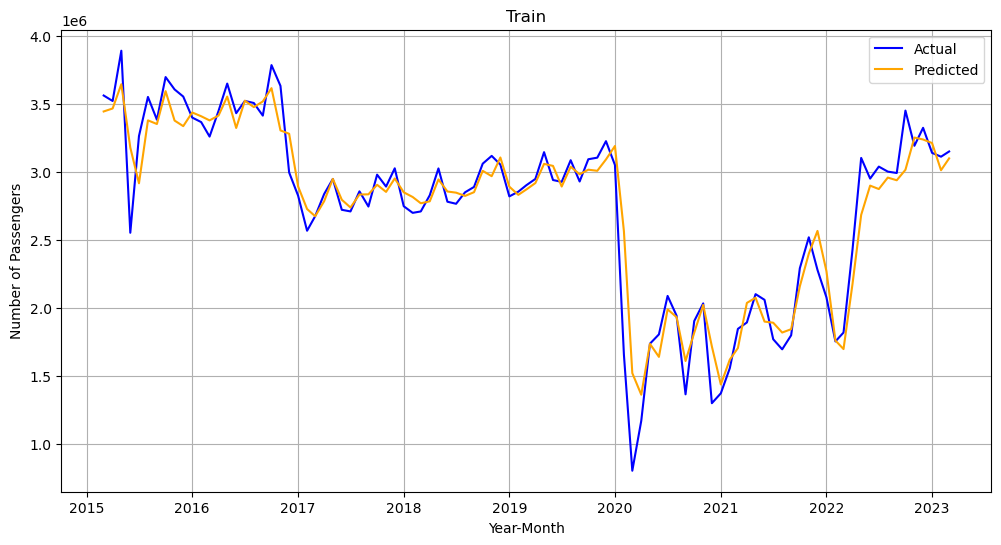

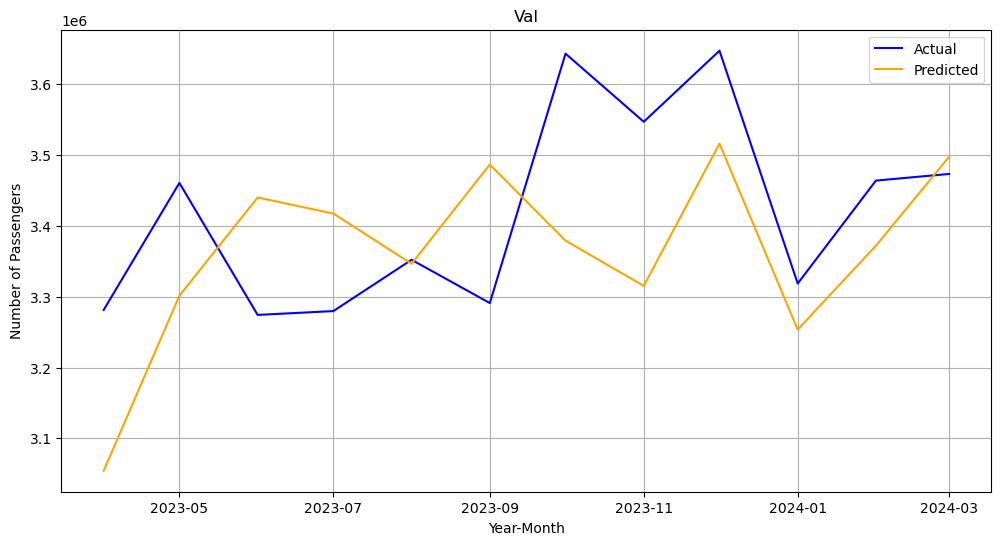

In [5]:
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data, df_gbline = preprocess_data(file_path)

# RandomForest 모델 평가
best_rf_model, rf_results = model_rf(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(rf_results['best_hyperparams'])

print('Random Forest(Train):')
print(f"R-squared: {rf_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['train_metrics']['mape']:.2f}%")
print()
print('Random Forest(Val):')
print(f"R-squared: {rf_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rf_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rf_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rf_results['val_metrics']['mape']:.2f}%")

Y_train_pred_rf = best_rf_model.predict(X_train_scaled)
Y_val_pred_rf = best_rf_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_rf, Y_val, Y_val_pred_rf)

# XGBoost

100%|███████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 87491.45833333333]
The best hyperparameters :  

{'colsample_bytree': 0.8322292937774338, 'gamma': 0.15118919380308812, 'learning_rate': 0.2476023574093126, 'max_depth': 3.0, 'n_estimators': 240.0, 'reg_alpha': 0.2713796356183338, 'reg_lambda': 0.1555683163565302, 'subsample': 0.8689251536417485}
XGBoost(Train):
R-squared: 1.00
MAE: 480.06
MSE: 351989.71
MAPE: 0.02%

XGBoost(Val):
R-squared: 0.34
MAE: 87491.46
MSE: 11834352137.88
MAPE: 2.58%


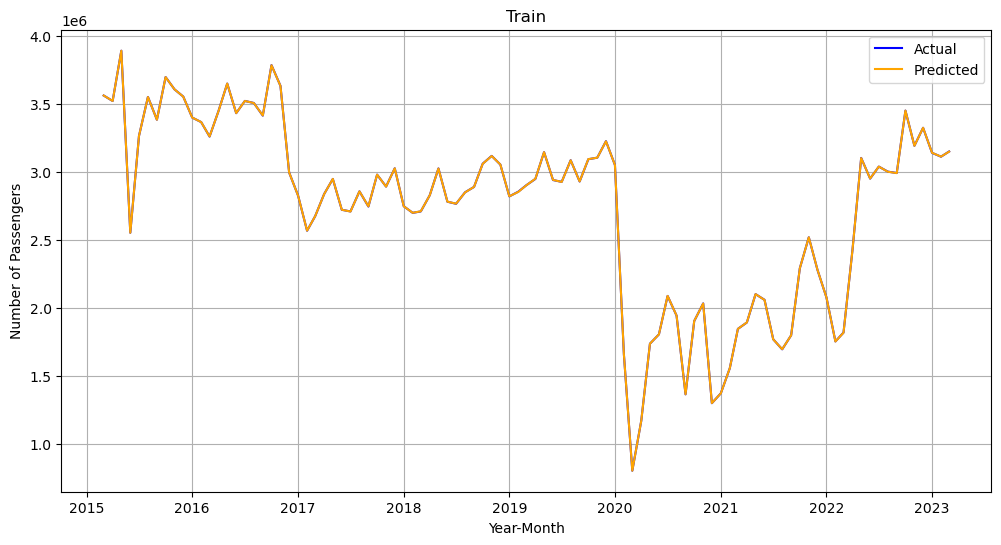

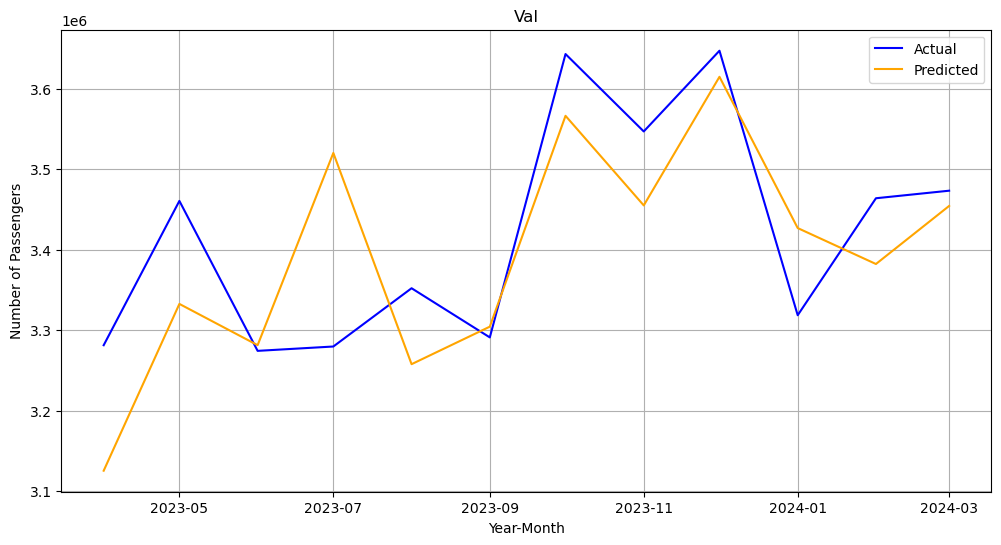

In [6]:
# XGBoost 모델 평가
best_xgb_model, xgb_results = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val, max_evals=100)
print("The best hyperparameters : ", "\n")
print(xgb_results['best_hyperparams'])

print('XGBoost(Train):')
print(f"R-squared: {xgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['train_metrics']['mape']:.2f}%")
print()
print('XGBoost(Val):')
print(f"R-squared: {xgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {xgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {xgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {xgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_xgb = best_xgb_model.predict(X_train_scaled)
Y_val_pred_xgb = best_xgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_xgb, Y_val, Y_val_pred_xgb)
#{'colsample_bytree': 0.8922607113389976, 'gamma': 0.29202225637784096, 'learning_rate': 0.10486928608249282, 'max_depth': 6.0, 'n_estimators': 280.0, 'reg_alpha': 0.9413775711280722, 'reg_lambda': 0.8990091066271554, 'subsample': 0.8712113355918811}

# LightGBM

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114
[LightGBM] [Info] Number of data points in the train set: 97, number of used features: 6
[LightGBM] [Info] Start training from score 2752700.144330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

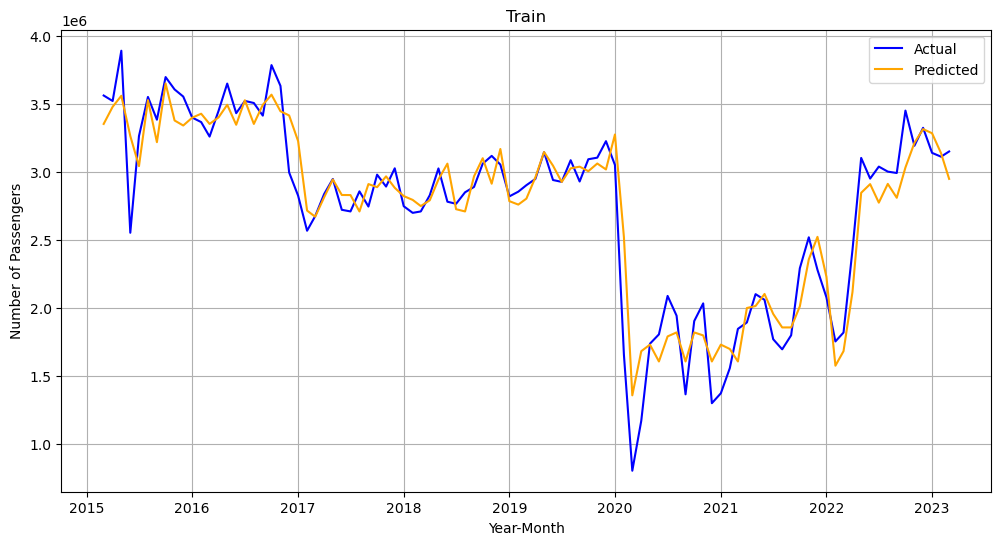

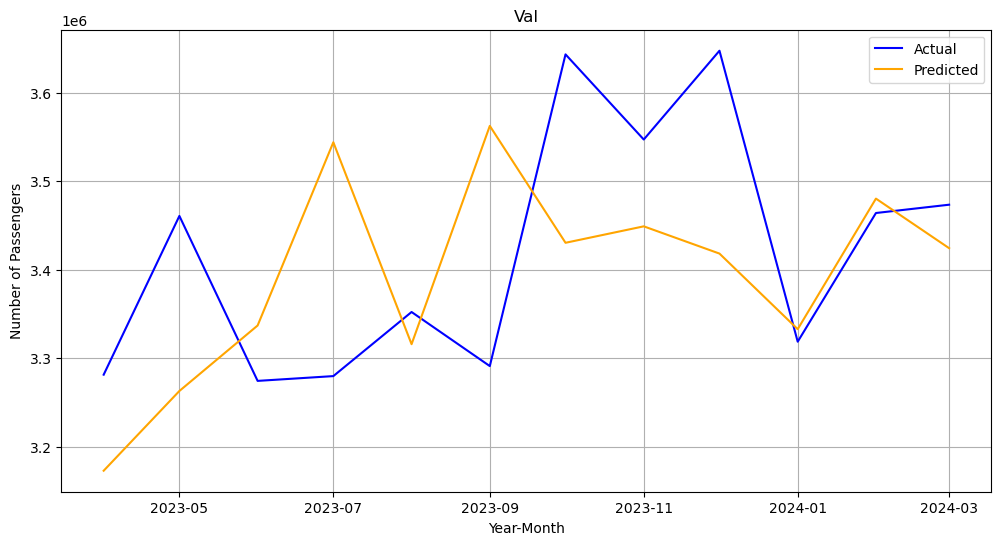

In [7]:
best_lgb_model, lgb_results = model_lightgbm(X_train_scaled, Y_train, X_val_scaled, Y_val)
print("LightGBM(Train):")
print(f"R-squared: {lgb_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['train_metrics']['mape']:.2f}%")
print()
print("LightGBM(Val):")
print(f"R-squared: {lgb_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lgb_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lgb_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lgb_results['val_metrics']['mape']:.2f}%")

Y_train_pred_lgb = best_lgb_model.predict(X_train_scaled)
Y_val_pred_lgb = best_lgb_model.predict(X_val_scaled)

plot_results(train_data, val_data, Y_train, Y_train_pred_lgb, Y_val, Y_val_pred_lgb)


# DL(LSTM, GRU, CNN, RNN)

## 전처리

In [8]:
def preprocessing_dl(df):
    # 시간정보 datetime 형식으로 변환
    if '운행년월' in df.columns:
        df['DateTime'] = pd.to_datetime(df['운행년월'])
    
    #index 시간정보로 변경
    if df.index.dtype == 'int64':
        df.set_index('DateTime', inplace=True)

    duplicate_index = df.index[df.index.duplicated()]

    # 중복 인덱스 제거
    df = df[~df.index.duplicated(keep='first')]

    # 결측값 처리 
    df.fillna(method='ffill', inplace=True)
    
    # 월 단위로 시간정보 설정
    df = df.asfreq('MS')
    
    # Lagged Variables 추가
    df['승차인원수_T1'] = df['승차인원수'].shift(1)
    df['승차인원수_T2'] = df['승차인원수'].shift(2)
    df.dropna(subset=['승차인원수_T1', '승차인원수_T2'], inplace=True)
    
    # Train & Val 데이터 분할
    df_train = df.loc[df.index >= '2015-01-01']
    df_train = df_train.loc[df_train.index < '2023-04-01']
    df_val = df.loc[df.index >= '2023-04-01']
    
    # 종속변수와 독립변수 결정
    Y_colname = ['승차인원수']
    X_colname = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수','승차인원수_T1','승차인원수_T2']
    
    # X_train, Y_train, X_test, Y_test 분할
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_val = df_val[Y_colname]
    X_val = df_val[X_colname]
    
    return X_train, X_val, Y_train, Y_val

# 파일 경로 및 불러오기
file_path = r"C:\Users\james\DATA_LAB\KTX_Forecasting\data\ktx_20240720.xlsx"
df = pd.read_excel(file_path)

# 데이터 전처리
X_train, X_val, Y_train, Y_val = preprocessing_dl(df)

# 데이터 스케일링
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)

Y_train_scaled = scaler_Y.fit_transform(Y_train)
Y_val_scaled = scaler_Y.transform(Y_val)
    
print('---------------Train----------------')
print('Normalized X: ', X_train_scaled.shape, X_train_scaled.min(), X_train_scaled.max())
print('Normalized Y: ', Y_train_scaled.shape, Y_train_scaled.min(), Y_train_scaled.max())
print('----------------Test----------------')
print('Normalized X: ', X_val_scaled.shape, X_val_scaled.min(), X_val_scaled.max())
print('Normalized Y: ', Y_val_scaled.shape, Y_val_scaled.min(), Y_val_scaled.max())

---------------Train----------------
Normalized X:  (97, 7) 0.0 1.0
Normalized Y:  (97, 1) 0.0 1.0
----------------Test----------------
Normalized X:  (12, 7) 0.0 1.0
Normalized Y:  (12, 1) 0.799528311800515 0.9201945471317976


## 하이퍼파라미터

In [9]:
# 하이퍼파라미터
tf.random.set_seed(1)
KERNEL_SIZE = 3
STRIDE = 1
POOL_SIZE = 2
POOL_STRIDE = 2
PADDING = 'same'
HIDDEN_ACTIVATION = 'relu'
OUTPUT_ACTIVATION = 'linear'
REGULARIZER = regularizers.l2(0.01)
DROPOUT_RATIO = 0.25
LOSS = 'mse'
LEARNING_RATE = 0.01
OPTIMIZER = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['mse']
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 0

## 시각화 함수

In [10]:
def plot_results2(train_data, val_data, Y_train, Y_train_pred, Y_val, Y_val_pred):
    # Train 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[time_step:], Y_train, label='Actual', color='blue')
    plt.plot(train_data.index[time_step:], Y_train_pred, label='Pred', color='orange')
    plt.title('Train')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Val 데이터 시각화
    plt.figure(figsize=(12, 6))
    plt.plot(val_data.index[time_step:], Y_val, label='Actual', color='blue')
    plt.plot(val_data.index[time_step:], Y_val_pred, label='Pred', color='orange')
    plt.title('Val')
    plt.xlabel('DateTime')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.grid(True)
    plt.show()

# LSTM

In [11]:
def reshape_for_lstm(X, Y, time_step):
    X_reshaped = []
    Y_reshaped = []
    for i in range(len(X) - time_step):
        X_reshaped.append(X[i:i + time_step])
        Y_reshaped.append(Y[i + time_step])
    return np.array(X_reshaped), np.array(Y_reshaped)

time_step = 3

# Train 재구성
X_train_lstm, Y_train_lstm = reshape_for_lstm(X_train_scaled, Y_train_scaled, time_step)

# Val 재구성
X_val_lstm, Y_val_lstm = reshape_for_lstm(X_val_scaled, Y_val_scaled, time_step)

print("X_train_lstm shape:", X_train_lstm.shape)
print("Y_train_lstm shape:", Y_train_lstm.shape)
print("X_val_lstm shape:", X_val_lstm.shape)
print("Y_val_lstm shape:", Y_val_lstm.shape)

X_train_lstm shape: (94, 3, 7)
Y_train_lstm shape: (94, 1)
X_val_lstm shape: (9, 3, 7)
Y_val_lstm shape: (9, 1)


In [12]:
# LSTM 모델 정의
#model = Sequential()
#model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
#model.add(LSTM(50, return_sequences=False))
#model.add(Dense(Y_train_scaled.shape[1]))


model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
model.add(Dropout(0.3))
#model.add(LSTM(50, return_sequences=True))
#model.add(Dropout(0.3))
model.add(LSTM(25, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 컴파일
#model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)

# 모델 요약 출력
model.summary()

# 모델 학습
history = model.fit(X_train_lstm, Y_train_lstm, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                               ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
  #                           validation_data=(X_val, Y_val), verbose=2, 
    #                         callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# 모델 예측
Y_train_pred_lstm = model.predict(X_train_lstm)
Y_val_pred_lstm = model.predict(X_val_lstm)

# 역변환
Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_lstm)
Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_lstm)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 50)             11600     
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 25)                7600      
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 19226 (75.10 KB)
Trainable params: 19226 (75.10 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100

2/2 -

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))  # 두 번째 LSTM 레이어 활성화
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))  # 활성화 함수 변경

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(X_train_lstm, Y_train_lstm, 
                    epochs=100, 
                    batch_size=64, 
                    validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=7.5),  # 조정
                               ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.05)])  # factor 값을 0.1에서 0.05로 조정

Y_train_pred_lstm = model.predict(X_train_lstm)
Y_val_pred_lstm = model.predict(X_val_lstm)

Y_train_pred = scaler_Y.inverse_transform(Y_train_pred_lstm)
Y_val_pred = scaler_Y.inverse_transform(Y_val_pred_lstm)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 50)             11600     
                                                                 
 dropout_4 (Dropout)         (None, 3, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31851 (124.42 KB)
Trainable params: 31851 (124.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 

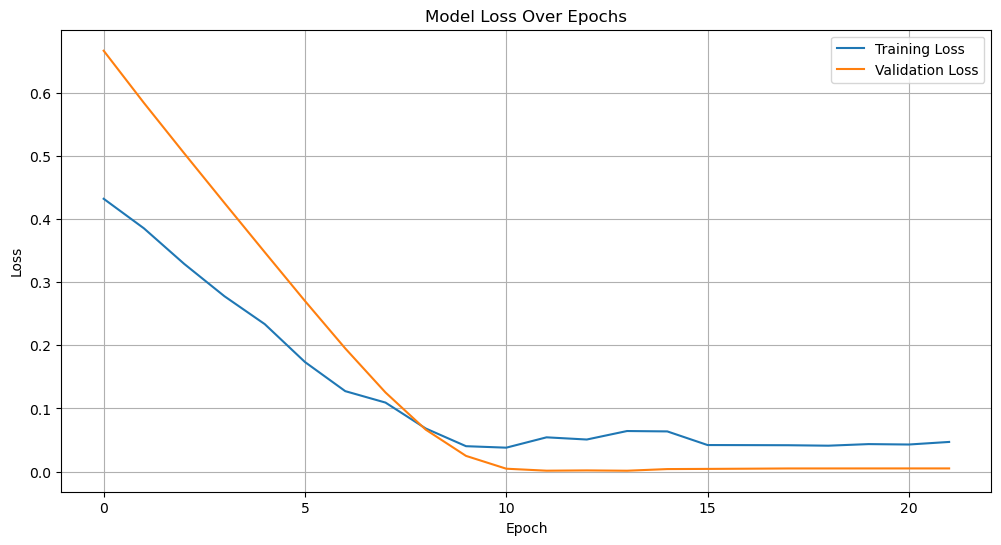

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

LSTM(Train):
R-squared: 0.27
MAE: 371309.57
MSE: 318963999435.55
MAPE: 20.46%

LSTM(Val):
R-squared: -1.61
MAE: 188382.58
MSE: 48664476565.80
MAPE: 5.39%


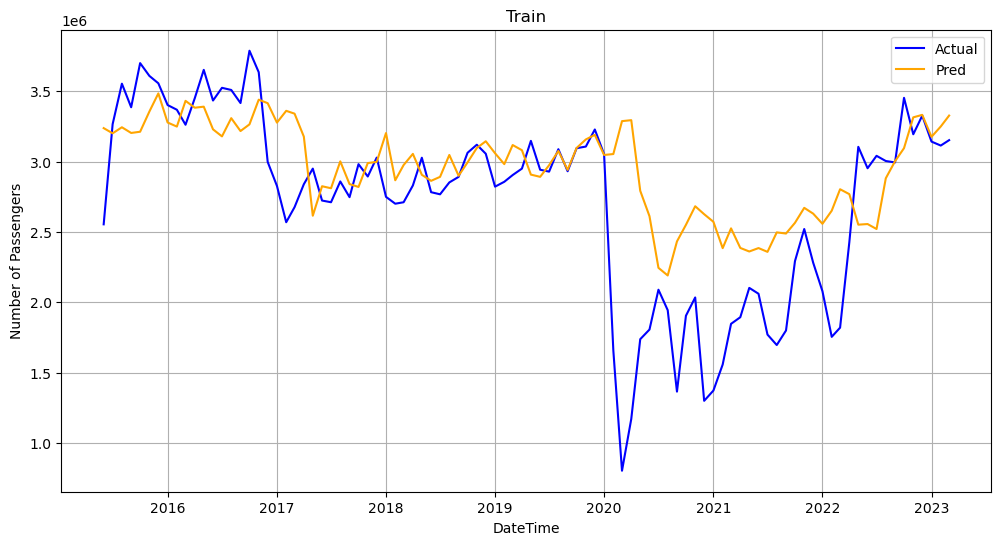

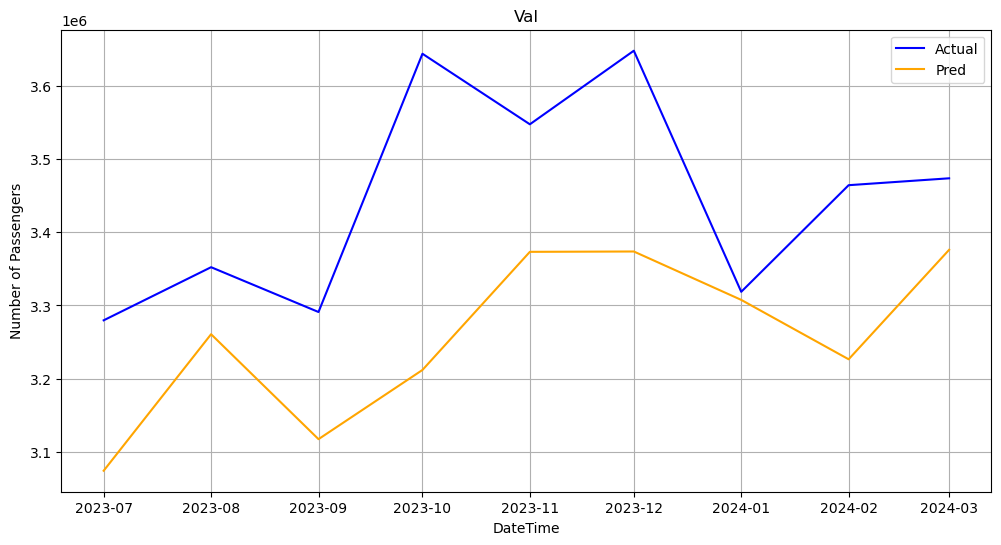

In [18]:
# 지표 계산
train_r_squared = r2_score(Y_train_actual, Y_train_pred)
train_mae = mean_absolute_error(Y_train_actual, Y_train_pred)
train_mse = mean_squared_error(Y_train_actual, Y_train_pred)
train_mape = np.mean(np.abs((Y_train_actual - Y_train_pred) / Y_train_actual)) * 100

val_r_squared = r2_score(Y_val_actual, Y_val_pred)
val_mae = mean_absolute_error(Y_val_actual, Y_val_pred)
val_mse = mean_squared_error(Y_val_actual, Y_val_pred)
val_mape = np.mean(np.abs((Y_val_actual - Y_val_pred) / Y_val_actual)) * 100

lstm_results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('LSTM(Train):')
print(f"R-squared: {lstm_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {lstm_results['train_metrics']['mae']:.2f}")
print(f"MSE: {lstm_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {lstm_results['train_metrics']['mape']:.2f}%")
print()
print('LSTM(Val):')
print(f"R-squared: {lstm_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {lstm_results['val_metrics']['mae']:.2f}")
print(f"MSE: {lstm_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {lstm_results['val_metrics']['mape']:.2f}%")

# 시각화
plot_results2(X_train, Y_val, Y_train_actual, Y_train_pred, Y_val_actual, Y_val_pred)

# GRU

In [19]:
# GRU 모델 정의
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, X_train_scaled.shape[1])))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(25, return_sequences=False))
model_gru.add(Dropout(0.2))
model_gru.add(Dense(1, activation='linear'))
model_gru.compile(optimizer='adam', loss='mean_squared_error')

model_gru.summary()

# 모델 학습
history_gru = model_gru.fit(X_train_lstm, Y_train_lstm, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

# 모델 예측
Y_train_pred_gru = model_gru.predict(X_train_lstm)
Y_val_pred_gru = model_gru.predict(X_val_lstm)

# 역변환
Y_train_pred_gru = scaler_Y.inverse_transform(Y_train_pred_gru)
Y_val_pred_gru = scaler_Y.inverse_transform(Y_val_pred_gru)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 50)             8850      
                                                                 
 dropout_6 (Dropout)         (None, 3, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 25)                5775      
                                                                 
 dropout_7 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 14651 (57.23 KB)
Trainable params: 14651 (57.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2/2 - 

GRU(Train):
R-squared: 0.34
MAE: 413093.17
MSE: 287978876935.33
MAPE: 19.84%

GRU(Val):
R-squared: -13.28
MAE: 484819.00
MSE: 265842172498.17
MAPE: 13.91%


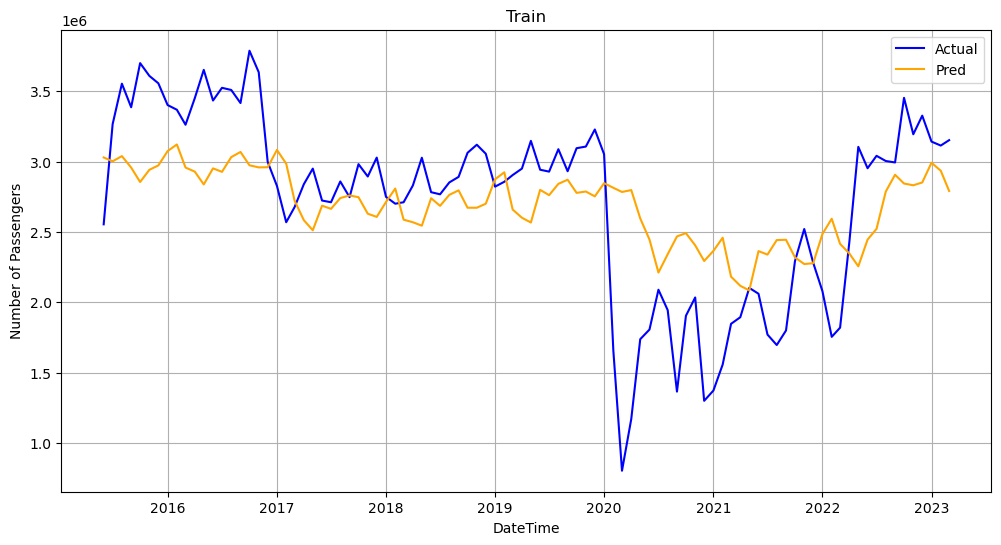

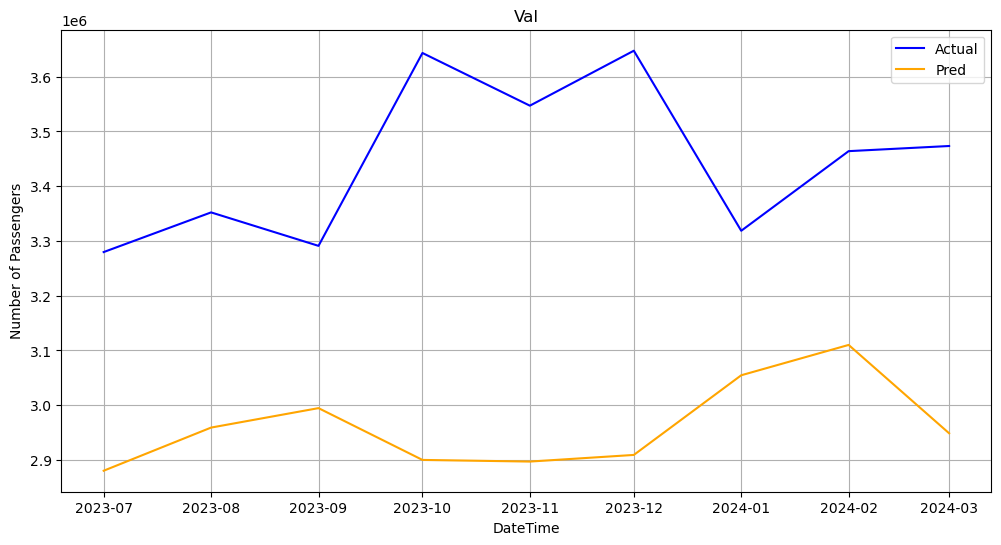

In [20]:
# 지표 계산
train_r_squared_gru = r2_score(Y_train_actual, Y_train_pred_gru)
train_mae_gru = mean_absolute_error(Y_train_actual, Y_train_pred_gru)
train_mse_gru = mean_squared_error(Y_train_actual, Y_train_pred_gru)
train_mape_gru = np.mean(np.abs((Y_train_actual - Y_train_pred_gru) / Y_train_actual)) * 100

val_r_squared_gru = r2_score(Y_val_actual, Y_val_pred_gru)
val_mae_gru = mean_absolute_error(Y_val_actual, Y_val_pred_gru)
val_mse_gru = mean_squared_error(Y_val_actual, Y_val_pred_gru)
val_mape_gru = np.mean(np.abs((Y_val_actual - Y_val_pred_gru) / Y_val_actual)) * 100

gru_results = {
    'train_metrics': {
        'r_squared': train_r_squared_gru,
        'mae': train_mae_gru,
        'mse': train_mse_gru,
        'mape': train_mape_gru
    },
    'val_metrics': {
        'r_squared': val_r_squared_gru,
        'mae': val_mae_gru,
        'mse': val_mse_gru,
        'mape': val_mape_gru
    }
}
print('GRU(Train):')
print(f"R-squared: {gru_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {gru_results['train_metrics']['mae']:.2f}")
print(f"MSE: {gru_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {gru_results['train_metrics']['mape']:.2f}%")
print()
print('GRU(Val):')
print(f"R-squared: {gru_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {gru_results['val_metrics']['mae']:.2f}")
print(f"MSE: {gru_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {gru_results['val_metrics']['mape']:.2f}%")

# 시각화
plot_results2(X_train, X_val, Y_train_actual, Y_train_pred_gru, Y_val_actual, Y_val_pred_gru)

# CNN

In [21]:
# CNN 모델 정의
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_step, X_train_scaled.shape[1])))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(optimizer='adam', loss='mean_squared_error')

model_cnn.summary()

# 모델 학습
history_cnn = model_cnn.fit(X_train_lstm, Y_train_lstm, 
                            epochs=100, 
                            batch_size=64, 
                            validation_data=(X_val_lstm, Y_val_lstm), verbose=2,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10),
                                       ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1)])

# 모델 예측
Y_train_pred_cnn = model_cnn.predict(X_train_lstm)
Y_val_pred_cnn = model_cnn.predict(X_val_lstm)

# 역변환
Y_train_pred_cnn = scaler_Y.inverse_transform(Y_train_pred_cnn)
Y_val_pred_cnn = scaler_Y.inverse_transform(Y_val_pred_cnn)

Y_train_actual = scaler_Y.inverse_transform(Y_train_lstm)
Y_val_actual = scaler_Y.inverse_transform(Y_val_lstm)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             1408      
                                                                 
 dropout_8 (Dropout)         (None, 1, 64)             0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4709 (18.39 KB)
Trainable params: 4709 (

CNN(Train):
R-squared: 0.28
MAE: 420090.26
MSE: 315141001074.94
MAPE: 19.76%

CNN(Val):
R-squared: -14.42
MAE: 478599.56
MSE: 287147076330.90
MAPE: 13.83%


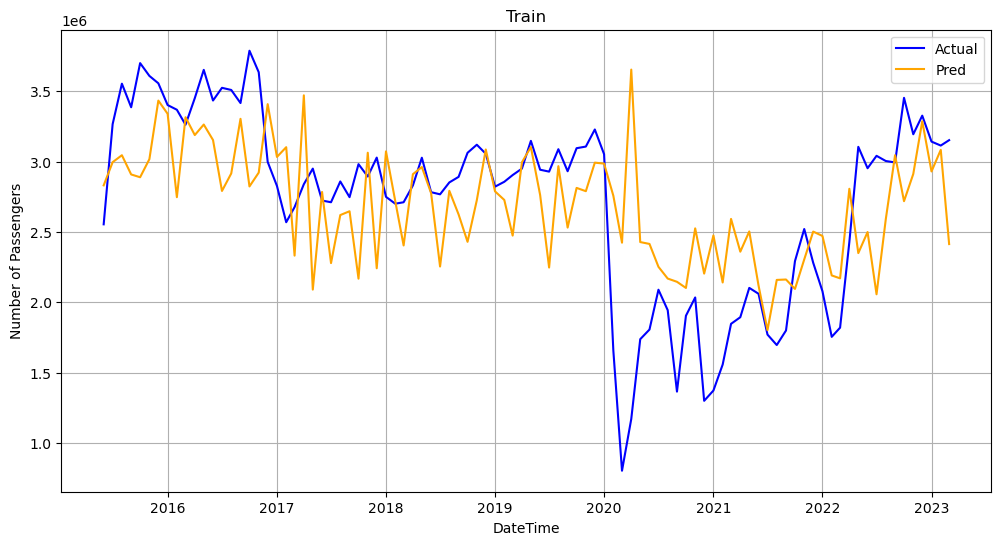

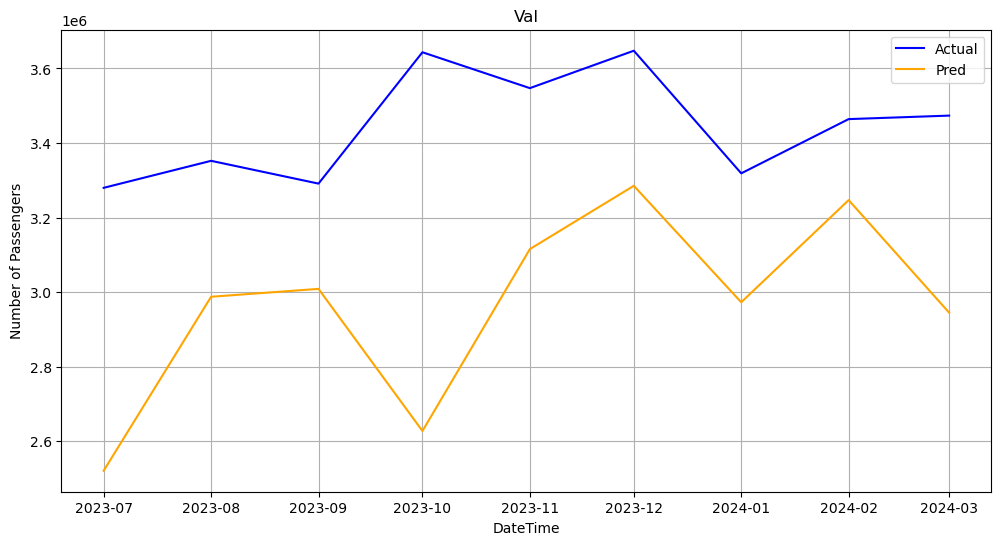

In [22]:
# 지표 계산
train_r_squared_cnn = r2_score(Y_train_actual, Y_train_pred_cnn)
train_mae_cnn = mean_absolute_error(Y_train_actual, Y_train_pred_cnn)
train_mse_cnn = mean_squared_error(Y_train_actual, Y_train_pred_cnn)
train_mape_cnn = np.mean(np.abs((Y_train_actual - Y_train_pred_cnn) / Y_train_actual)) * 100

val_r_squared_cnn = r2_score(Y_val_actual, Y_val_pred_cnn)
val_mae_cnn = mean_absolute_error(Y_val_actual, Y_val_pred_cnn)
val_mse_cnn = mean_squared_error(Y_val_actual, Y_val_pred_cnn)
val_mape_cnn = np.mean(np.abs((Y_val_actual - Y_val_pred_cnn) / Y_val_actual)) * 100

cnn_results = {
    'train_metrics': {
        'r_squared': train_r_squared_cnn,
        'mae': train_mae_cnn,
        'mse': train_mse_cnn,
        'mape': train_mape_cnn
    },
    'val_metrics': {
        'r_squared': val_r_squared_cnn,
        'mae': val_mae_cnn,
        'mse': val_mse_cnn,
        'mape': val_mape_cnn
    }
}

print('CNN(Train):')
print(f"R-squared: {cnn_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {cnn_results['train_metrics']['mae']:.2f}")
print(f"MSE: {cnn_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {cnn_results['train_metrics']['mape']:.2f}%")
print()
print('CNN(Val):')
print(f"R-squared: {cnn_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {cnn_results['val_metrics']['mae']:.2f}")
print(f"MSE: {cnn_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {cnn_results['val_metrics']['mape']:.2f}%")

# 시각화 호출
plot_results2(X_train, X_val, Y_train_actual, Y_train_pred_cnn, Y_val_actual, Y_val_pred_cnn)

# RNN

In [23]:
def preprocess_rnn(X, Y):
    X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
    Y_reshaped = Y.reshape((Y.shape[0], 1))
    return X_reshaped, Y_reshaped

X_train_rnn, Y_train_rnn = preprocess_rnn(X_train_scaled, Y_train_scaled)
X_val_rnn, Y_val_rnn = preprocess_rnn(X_val_scaled, Y_val_scaled)

# RNN 모델 생성 함수
def create_rnn(input_shape):
    model = Sequential()
    model.add(SimpleRNN(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(SimpleRNN(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# RNN 모델 학습 함수
def model_rnn(X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
    input_shape = (X_train.shape[1], X_train.shape[2])
    rnn_model = create_rnn(input_shape)

    history = rnn_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                            validation_data=(X_val, Y_val), verbose=2, 
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

    Y_train_pred = rnn_model.predict(X_train)
    Y_val_pred = rnn_model.predict(X_val)

    return rnn_model, Y_train_pred, Y_val_pred, history

# RNN 모델 평가
best_rnn_model, Y_train_pred_rnn, Y_val_pred_rnn, history = model_rnn(X_train_rnn, Y_train_rnn, X_val_rnn, Y_val_rnn, epochs=100, batch_size=64)

# 역변환
Y_train_pred_rnn = scaler_Y.inverse_transform(Y_train_pred_rnn)
Y_val_pred_rnn = scaler_Y.inverse_transform(Y_val_pred_rnn)
Y_train_rnn = scaler_Y.inverse_transform(Y_train_rnn)
Y_val_rnn = scaler_Y.inverse_transform(Y_val_rnn)

Epoch 1/100
2/2 - 10s - loss: 0.2804 - val_loss: 0.0161 - 10s/epoch - 5s/step
Epoch 2/100
2/2 - 0s - loss: 0.1956 - val_loss: 0.0196 - 137ms/epoch - 68ms/step
Epoch 3/100
2/2 - 0s - loss: 0.2204 - val_loss: 0.0429 - 135ms/epoch - 68ms/step
Epoch 4/100
2/2 - 0s - loss: 0.1598 - val_loss: 0.1058 - 144ms/epoch - 72ms/step
Epoch 5/100
2/2 - 0s - loss: 0.1268 - val_loss: 0.0732 - 131ms/epoch - 65ms/step
Epoch 6/100
2/2 - 0s - loss: 0.1180 - val_loss: 0.0238 - 129ms/epoch - 65ms/step
Epoch 7/100
2/2 - 0s - loss: 0.1016 - val_loss: 0.0101 - 154ms/epoch - 77ms/step
Epoch 8/100
2/2 - 0s - loss: 0.1206 - val_loss: 0.0105 - 134ms/epoch - 67ms/step
Epoch 9/100
2/2 - 0s - loss: 0.0948 - val_loss: 0.0091 - 148ms/epoch - 74ms/step
Epoch 10/100
2/2 - 0s - loss: 0.0991 - val_loss: 0.0050 - 141ms/epoch - 71ms/step
Epoch 11/100
2/2 - 0s - loss: 0.0662 - val_loss: 0.0076 - 130ms/epoch - 65ms/step
Epoch 12/100
2/2 - 0s - loss: 0.0827 - val_loss: 0.0127 - 137ms/epoch - 68ms/step
Epoch 13/100
2/2 - 0s - loss

RNN(Train):
R-squared: 0.27
MAE: 371309.57
MSE: 318963999435.55
MAPE: 20.46%

RNN(Val):
R-squared: -1.61
MAE: 188382.58
MSE: 48664476565.80
MAPE: 5.39%


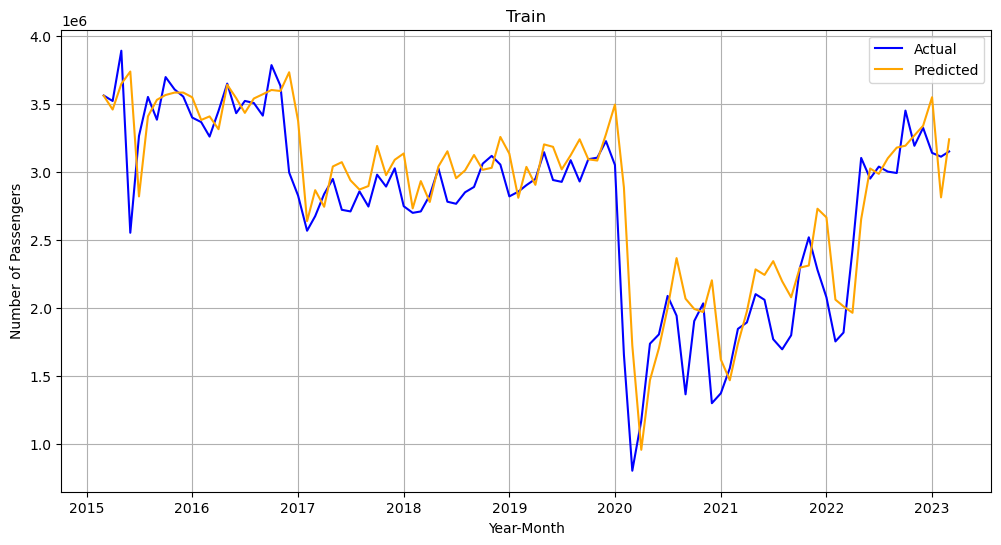

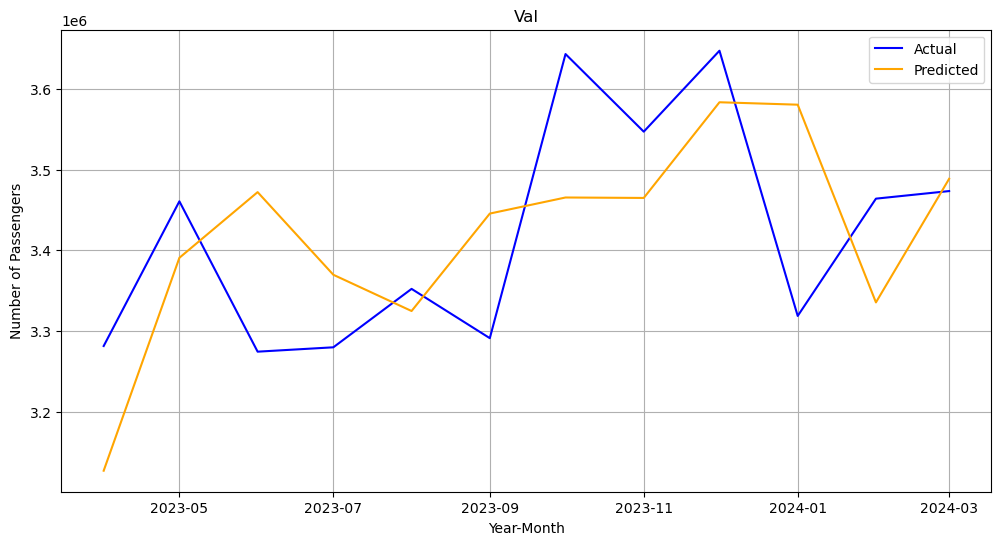

In [24]:
rnn_results = {
    'train_metrics': {
        'r_squared': train_r_squared,
        'mae': train_mae,
        'mse': train_mse,
        'mape': train_mape
    },
    'val_metrics': {
        'r_squared': val_r_squared,
        'mae': val_mae,
        'mse': val_mse,
        'mape': val_mape
    }
}

print('RNN(Train):')
print(f"R-squared: {rnn_results['train_metrics']['r_squared']:.2f}")
print(f"MAE: {rnn_results['train_metrics']['mae']:.2f}")
print(f"MSE: {rnn_results['train_metrics']['mse']:.2f}")
print(f"MAPE: {rnn_results['train_metrics']['mape']:.2f}%")
print()
print('RNN(Val):')
print(f"R-squared: {rnn_results['val_metrics']['r_squared']:.2f}")
print(f"MAE: {rnn_results['val_metrics']['mae']:.2f}")
print(f"MSE: {rnn_results['val_metrics']['mse']:.2f}")
print(f"MAPE: {rnn_results['val_metrics']['mape']:.2f}%")

plot_results(train_data, val_data, Y_train_rnn, Y_train_pred_rnn, Y_val_rnn, Y_val_pred_rnn)

# 모델 평가

In [26]:
models = ['RandomForest', 'XGBoost', 'LightGBM', 'LSTM', 'GRU', 'CNN', 'RNN']
 
val_mae = [
    rf_results['val_metrics']['mae'],
    xgb_results['val_metrics']['mae'],
    lgb_results['val_metrics']['mae'],
    lstm_results['val_metrics']['mae'],
    gru_results['val_metrics']['mae'],
    cnn_results['val_metrics']['mae'],
    rnn_results['val_metrics']['mae']
]

val_mse = [
    rf_results['val_metrics']['mse'],
    xgb_results['val_metrics']['mse'],
    lgb_results['val_metrics']['mse'],
    lstm_results['val_metrics']['mse'],
    gru_results['val_metrics']['mse'],
    cnn_results['val_metrics']['mse'],
    rnn_results['val_metrics']['mse']
]

val_mape = [
    rf_results['val_metrics']['mape'],
    xgb_results['val_metrics']['mape'],
    lgb_results['val_metrics']['mape'],
    lstm_results['val_metrics']['mape'],
    gru_results['val_metrics']['mape'],
    cnn_results['val_metrics']['mape'],
    rnn_results['val_metrics']['mape']
]

data = {
    'Model': models,
    'MAE': val_mae,
    'MSE': val_mse,
    'MAPE': val_mape
}

df = pd.DataFrame(data)

# MAPE를 기준으로 정렬
df_sorted = df.sort_values(by='MAPE')

# 결과 출력
display(df_sorted)

,Model,MAE,MSE,MAPE
1,XGBoost,87491.458333,1.183435e+10,2.582753
2,LightGBM,130092.197474,2.584648e+10,3.794834
0,RandomForest,141668.927525,2.632023e+10,4.133836
3,LSTM,188382.583333,4.866448e+10,5.389513
6,RNN,188382.583333,4.866448e+10,5.389513
5,CNN,478599.555556,2.871471e+11,13.832178
4,GRU,484819.000000,2.658422e+11,13.906834


In [28]:
# XGBoost 모델 저장
best_xgb_model.save_model('xgboost_model.xgb')

# Test(2024년4월~2025년12월)

In [75]:
# 주말/주중 변수 생성 함수
def create_weekend_weekday(df):
    df['요일'] = df['운행일자'].dt.weekday
    weekday_list = ['월', '화', '수', '목', '금', '토', '일']
    df['요일'] = df['요일'].apply(lambda x: weekday_list[x])
    df['주말여부'] = df['요일'].apply(lambda x: '주말' if x in ['금', '토', '일'] else '주중')
    return df

# 공휴일 변수 생성 함수
kr_holidays = holidays.KR()
def is_holiday(date):
    return date in kr_holidays

def create_holiday_variable(df):
    df['공휴일여부'] = df['운행일자'].apply(lambda x: '공휴일' if is_holiday(x) else '평일')
    return df

# 명절 변수 생성 함수
seollal_dates = pd.to_datetime(['2024-02-10', '2025-01-29'])
chuseok_dates = pd.to_datetime(['2024-09-17', '2025-10-06'])
seollal_holidays = seollal_dates.union(seollal_dates - timedelta(days=1)).union(seollal_dates + timedelta(days=1))
chuseok_holidays = chuseok_dates.union(chuseok_dates - timedelta(days=1)).union(chuseok_dates + timedelta(days=1))

def create_festival_variable(df):
    df['명절여부'] = df['운행일자'].apply(lambda x: '명절' if x in seollal_holidays or x in chuseok_holidays else '비명절')
    return df

# 2024년 4월부터 2025년 12월까지의 일자별 데이터 생성
all_dates = pd.date_range(start='2024-04-01', end='2025-12-31', freq='D')
date_info = pd.DataFrame(all_dates, columns=['운행일자'])

# 주말, 공휴일, 명절 여부 계산
date_info = create_weekend_weekday(date_info)
date_info = create_holiday_variable(date_info)
date_info = create_festival_variable(date_info)
date_info['운행년월'] = date_info['운행일자'].dt.to_period('M')

# 월별 변수 집계
monthly_info = date_info.groupby('운행년월').agg({
    '주말여부': lambda x: (x == '주말').sum(),
    '공휴일여부': lambda x: (x == '공휴일').sum(),
    '명절여부': lambda x: (x == '명절').sum(),
    '요일': 'count'  # 총 일수 계산
}).rename(columns={'주말여부': '주말수', '공휴일여부': '공휴일수', '명절여부': '명절수', '요일': '총일수'}).reset_index()

# 평일수 계산
monthly_info['평일수'] = monthly_info['총일수'] - monthly_info['주말수'] - monthly_info['공휴일수']
monthly_info = monthly_info[['운행년월', '주말수', '공휴일수', '명절수', '평일수']]

test_df = monthly_info.copy()

print(test_df)


       운행년월  주말수  공휴일수  명절수  평일수
0   2024-04   12     1    0   17
1   2024-05   13     3    0   15
2   2024-06   14     1    0   15
3   2024-07   12     0    0   19
4   2024-08   14     1    0   16
5   2024-09   13     3    3   14
6   2024-10   12     2    0   17
7   2024-11   14     0    0   16
8   2024-12   13     1    0   17
9   2025-01   13     4    3   14
10  2025-02   12     0    0   16
11  2025-03   14     2    0   15
12  2025-04   12     0    0   18
13  2025-05   14     2    0   15
14  2025-06   13     1    0   16
15  2025-07   12     0    0   19
16  2025-08   15     1    0   15
17  2025-09   12     0    0   18
18  2025-10   13     6    3   12
19  2025-11   14     0    0   16
20  2025-12   12     1    0   18


In [76]:
vkospi_values = [
    18.489048, 16.337619, 16.667368, 16.561765, 35.151499, 
    20.149452, 18.161680, 17.175196, 17.196362, 17.219427, 
    17.238888, 17.258978, 17.279095, 17.296976, 17.316032, 
    17.331850, 17.345844, 17.357851, 17.369129, 17.379562, 
    17.389141
]

# VKOSPI 값 채우기
test_df['VKOSPI'] = vkospi_values

print(test_df)

       운행년월  주말수  공휴일수  명절수  평일수     VKOSPI
0   2024-04   12     1    0   17  18.489048
1   2024-05   13     3    0   15  16.337619
2   2024-06   14     1    0   15  16.667368
3   2024-07   12     0    0   19  16.561765
4   2024-08   14     1    0   16  35.151499
5   2024-09   13     3    3   14  20.149452
6   2024-10   12     2    0   17  18.161680
7   2024-11   14     0    0   16  17.175196
8   2024-12   13     1    0   17  17.196362
9   2025-01   13     4    3   14  17.219427
10  2025-02   12     0    0   16  17.238888
11  2025-03   14     2    0   15  17.258978
12  2025-04   12     0    0   18  17.279095
13  2025-05   14     2    0   15  17.296976
14  2025-06   13     1    0   16  17.316032
15  2025-07   12     0    0   19  17.331850
16  2025-08   15     1    0   15  17.345844
17  2025-09   12     0    0   18  17.357851
18  2025-10   13     6    3   12  17.369129
19  2025-11   14     0    0   16  17.379562
20  2025-12   12     1    0   18  17.389141


In [77]:
# '운행년월'을 datetime으로 변환
df_gbline['운행년월'] = pd.to_datetime(df_gbline['운행년월'], format='%Y-%m')

# 추출
df_filtered = df_gbline[(df_gbline['운행년월'] >= '2024-02-01') & (df_gbline['운행년월'] <= '2024-03-31')]
df_filtered = df_filtered[['운행년월', '승차인원수_T1', '승차인원수_T2']]

print(df_filtered)

          운행년월   승차인원수_T1   승차인원수_T2
109 2024-02-01  3318669.0  3647548.0
110 2024-03-01  3464111.0  3318669.0


In [78]:
# 필요한 값 추출
t1_value = df_filtered[df_filtered['운행년월'] == '2024-03-01']['승차인원수_T1'].values[0]
t2_value = df_filtered[df_filtered['운행년월'] == '2024-02-01']['승차인원수_T2'].values[0]

In [79]:
# 승차인원수_T1과 승차인원수_T2 값 추가
test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수_T1']  = t1_value
test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수_T2'] = t2_value

print(test_df)

       운행년월  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2
0   2024-04   12     1    0   17  18.489048  3464111.0  3647548.0
1   2024-05   13     3    0   15  16.337619        NaN        NaN
2   2024-06   14     1    0   15  16.667368        NaN        NaN
3   2024-07   12     0    0   19  16.561765        NaN        NaN
4   2024-08   14     1    0   16  35.151499        NaN        NaN
5   2024-09   13     3    3   14  20.149452        NaN        NaN
6   2024-10   12     2    0   17  18.161680        NaN        NaN
7   2024-11   14     0    0   16  17.175196        NaN        NaN
8   2024-12   13     1    0   17  17.196362        NaN        NaN
9   2025-01   13     4    3   14  17.219427        NaN        NaN
10  2025-02   12     0    0   16  17.238888        NaN        NaN
11  2025-03   14     2    0   15  17.258978        NaN        NaN
12  2025-04   12     0    0   18  17.279095        NaN        NaN
13  2025-05   14     2    0   15  17.296976        NaN        NaN
14  2025-0

In [80]:
# XGBoost 모델 로드
model = xgb.Booster()
model.load_model('xgboost_model.xgb')

In [81]:
test_data = test_df[test_df['운행년월'] == '2024-04']
test_data2 = test_data.drop(columns=['운행년월'])
test_df2 = pd.DataFrame(test_data2)

# XGBoost DMatrix 객체 생성
dtest = xgb.DMatrix(test_df2)

# 예측 수행
predictions = model.predict(dtest)

# 결과 출력
print(f"2024-04 승차인원수 예측: {predictions[0]}")

2024-04 승차인원수 예측: 2332302.0


In [82]:
predicted_value = predictions[0]

test_df.loc[test_df['운행년월'] == '2024-04', '승차인원수'] = predicted_value

print(test_df)

       운행년월  주말수  공휴일수  명절수  평일수     VKOSPI   승차인원수_T1   승차인원수_T2      승차인원수
0   2024-04   12     1    0   17  18.489048  3464111.0  3647548.0  2332302.0
1   2024-05   13     3    0   15  16.337619        NaN        NaN        NaN
2   2024-06   14     1    0   15  16.667368        NaN        NaN        NaN
3   2024-07   12     0    0   19  16.561765        NaN        NaN        NaN
4   2024-08   14     1    0   16  35.151499        NaN        NaN        NaN
5   2024-09   13     3    3   14  20.149452        NaN        NaN        NaN
6   2024-10   12     2    0   17  18.161680        NaN        NaN        NaN
7   2024-11   14     0    0   16  17.175196        NaN        NaN        NaN
8   2024-12   13     1    0   17  17.196362        NaN        NaN        NaN
9   2025-01   13     4    3   14  17.219427        NaN        NaN        NaN
10  2025-02   12     0    0   16  17.238888        NaN        NaN        NaN
11  2025-03   14     2    0   15  17.258978        NaN        NaN        NaN

In [51]:
vko_df = pd.DataFrame({
    'Date': pd.date_range(start='2024-04-30', end='2025-12-31', freq='M'),
    'Forecast': [
        18.489048, 16.337619, 16.667368, 16.561765, 17.151499, 
        17.149452, 17.161680, 17.175196, 17.196362, 17.219427, 
        17.238888, 17.258978, 17.279095, 17.296976, 17.316032, 
        17.331850, 17.345844, 17.357851, 17.369129, 17.379562, 
        17.389141
    ]
})
vko_df['운행년월'] = vko_df['Date'].dt.to_period('M')


# 주말/주중 변수 생성 함수
def create_weekend_weekday(df):
    df['요일'] = df['운행일자'].dt.weekday
    weekday_list = ['월', '화', '수', '목', '금', '토', '일']
    df['요일'] = df['요일'].apply(lambda x: weekday_list[x])
    df['주말여부'] = df['요일'].apply(lambda x: '주말' if x in ['금', '토', '일'] else '주중')
    return df

# 공휴일 변수 생성 함수
kr_holidays = holidays.KR()
def is_holiday(date):
    return date in kr_holidays

def create_holiday_variable(df):
    df['공휴일여부'] = df['운행일자'].apply(lambda x: '공휴일' if is_holiday(x) else '평일')
    return df

# 명절 변수 생성 함수
seollal_dates = pd.to_datetime(['2024-02-10', '2025-01-29'])
chuseok_dates = pd.to_datetime(['2024-09-17', '2025-10-06'])

# 명절 연휴 포함 (설날, 설날 전날, 설날 다음날 / 추석, 추석 전날, 추석 다음날)
seollal_holidays = seollal_dates.union(seollal_dates - timedelta(days=1)).union(seollal_dates + timedelta(days=1))
chuseok_holidays = chuseok_dates.union(chuseok_dates - timedelta(days=1)).union(chuseok_dates + timedelta(days=1))

def create_festival_variable(df):
    df['명절여부'] = df['운행일자'].apply(lambda x: '명절' if x in seollal_holidays or x in chuseok_holidays else '비명절')
    return df

# 모든 날짜 범위에 대해 일자별 데이터 생성
all_dates = pd.date_range(start='2015-01-01', end='2025-12-31', freq='D')
date_info = pd.DataFrame(all_dates, columns=['운행일자'])

date_info = create_weekend_weekday(date_info)
date_info = create_holiday_variable(date_info)
date_info = create_festival_variable(date_info)
date_info['운행년월'] = date_info['운행일자'].dt.to_period('M')

# 월별 변수 계산
monthly_info = date_info.groupby('운행년월').agg({
    '주말여부': lambda x: (x == '주말').sum(),
    '공휴일여부': lambda x: (x == '공휴일').sum(),
    '명절여부': lambda x: (x == '명절').sum(),
    '요일': 'count'  # 총 일수 계산
}).rename(columns={'주말여부': '주말수', '공휴일여부': '공휴일수', '명절여부': '명절수', '요일': '총일수'}).reset_index()

# 총일수에서 주말수와 공휴일수를 빼서 평일수 계산
monthly_info['평일수'] = monthly_info['총일수'] - monthly_info['주말수'] - monthly_info['공휴일수']
monthly_info = monthly_info[['운행년월', '주말수', '공휴일수', '명절수', '평일수']]

# 테스트 데이터를 준비하는 함수
def prepare_test_data(train_data, start_date, end_date, monthly_info):
    # 테스트 기간에 대한 날짜 범위 생성
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    # 날짜 범위로 테스트 DataFrame 생성
    test_data = pd.DataFrame(date_range, columns=['운행년월'])
    test_data['운행년월'] = test_data['운행년월'].dt.to_period('M')
    
    # 월별 변수를 병합
    test_data = test_data.merge(monthly_info, on='운행년월', how='left')

    # 'VKOSPI' 값을 forecast_df에서 가져오기
    test_data = test_data.merge(vko_df[['운행년월', 'Forecast']], on='운행년월', how='left')
    test_data.rename(columns={'Forecast': 'VKOSPI'}, inplace=True)
    
    # 전년도 같은 달의 값을 사용하여  '승차인원수_T1', '승차인원수_T2' 채우기
    for idx, row in test_data.iterrows():
        prev_year_date = row['운행년월'] - 1  # Period 객체는 바로 숫자를 빼면 됩니다.
        prev_year_data = train_data[train_data['운행년월'] == prev_year_date]
        if not prev_year_data.empty:
            
            test_data.at[idx, '승차인원수_T1'] = prev_year_data['승차인원수'].values[0]
            prev_year_date_T2 = prev_year_date - 1
            prev_year_data_T2 = train_data[train_data['운행년월'] == prev_year_date_T2]
            test_data.at[idx, '승차인원수_T2'] = prev_year_data_T2['승차인원수'].values[0] if not prev_year_data_T2.empty else np.nan
        else:
            
            test_data.at[idx, '승차인원수_T1'] = np.nan
            test_data.at[idx, '승차인원수_T2'] = np.nan

    # NaN 값이 있는 행 제거
    test_data.dropna(subset=['승차인원수_T1', '승차인원수_T2', 'VKOSPI'], inplace=True)

    # test_data가 비어 있으면 기본값으로 채우기
    if test_data.empty:
        test_data = pd.DataFrame(date_range, columns=['운행년월'])
        test_data['운행년월'] = test_data['운행년월'].dt.to_period('M')
        test_data = test_data.merge(monthly_info, on='운행년월', how='left')
        #test_data['VKOSPI'] = 0
        test_data['승차인원수_T1'] = 0
        test_data['승차인원수_T2'] = 0

    return test_data

In [52]:
# 훈련 데이터 준비
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 테스트 데이터 준비
start_date = '2024-04-01'
end_date = '2025-12-31'
test_data = prepare_test_data(train_data, start_date, end_date, monthly_info)

# 특성 선택
features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']
X_test = test_data[features]

# 테스트 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(X_train_scaled)  # 기존 훈련 데이터로 스케일러를 피팅합니다.
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 훈련된 XGBoost 모델로 예측
best_xgb_model, _ = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val)
Y_test_pred = best_xgb_model.predict(X_test_scaled)

# 예측값을 테스트 데이터에 추가
test_data['승차인원수_예측'] = Y_test_pred

# 결과 출력
print(test_data[['운행년월', '승차인원수_예측']])

ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required by MinMaxScaler.

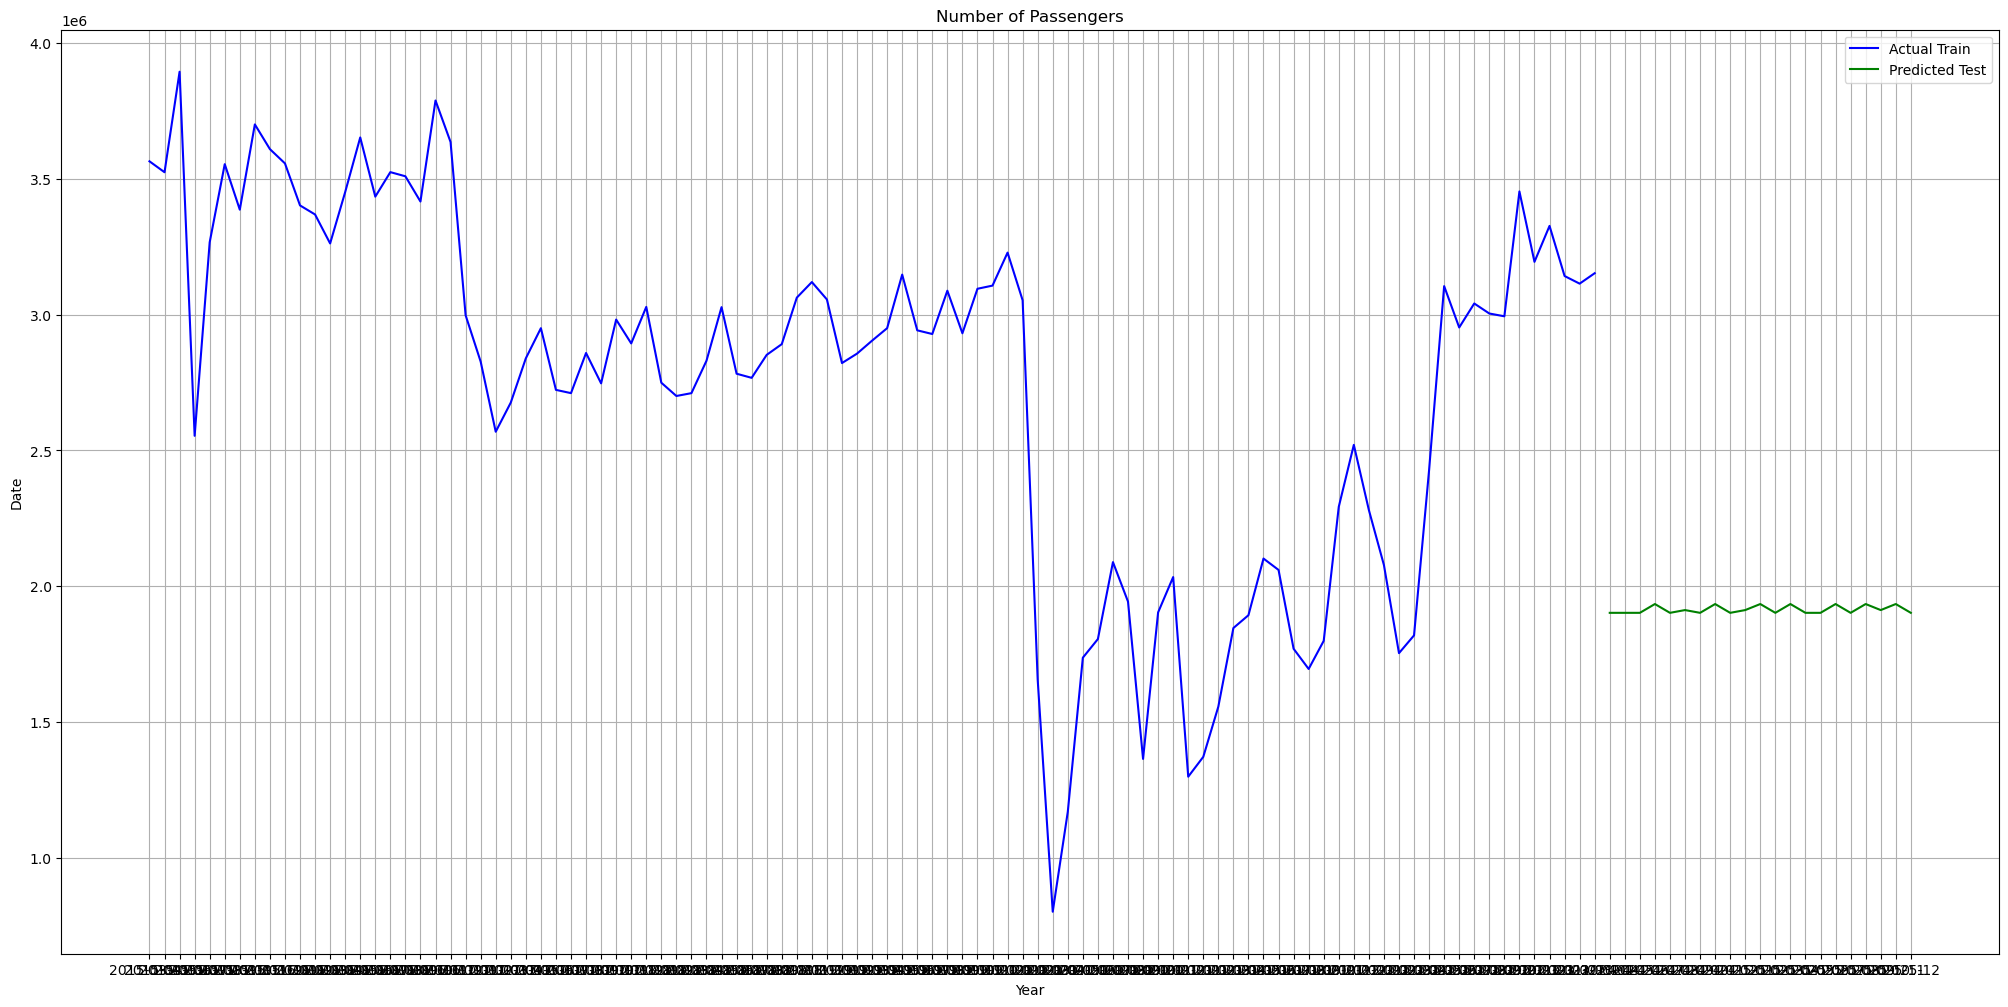

In [31]:
# 테스트 데이터의 예측값을 시각화
def plot_test_predictions(train_data, test_data, Y_train, Y_train_pred_xgb, Y_test_pred):
    plt.figure(figsize=(25, 12))
    
    # 훈련 데이터의 실제 값과 예측 값
    plt.plot(train_data['운행년월'].astype(str), Y_train, color='b', label='Actual Train')


    # 테스트 데이터의 예측 값
    plt.plot(test_data['운행년월'].astype(str), Y_test_pred, color='g', label='Predicted Test')

    plt.xlabel("Year")
    plt.ylabel("Date")
    plt.title("Number of Passengers")
    plt.legend()
    plt.grid(True)
    plt.grid(True)
    plt.show()

plot_test_predictions(train_data, test_data, Y_train, Y_train_pred_xgb, Y_test_pred)

In [50]:
print(test_data)

       운행년월  주말수  공휴일수  명절수  평일수  VKOSPI  승차인원수_T1  승차인원수_T2     승차인원수_예측
0   2024-04   12     1    0   17       0         0         0  2060599.625
1   2024-05   13     3    0   15       0         0         0  2060599.625
2   2024-06   14     1    0   15       0         0         0  2060599.625
3   2024-07   12     0    0   19       0         0         0  2081731.625
4   2024-08   14     1    0   16       0         0         0  2060599.625
5   2024-09   13     3    3   14       0         0         0  2010842.375
6   2024-10   12     2    0   17       0         0         0  2060599.625
7   2024-11   14     0    0   16       0         0         0  2081731.625
8   2024-12   13     1    0   17       0         0         0  2060599.625
9   2025-01   13     4    3   14       0         0         0  2010842.375
10  2025-02   12     0    0   16       0         0         0  2081731.625
11  2025-03   14     2    0   15       0         0         0  2060599.625
12  2025-04   12     0    0   18      

In [42]:
# 1. VKOSPI 값과 날짜를 포함한 데이터프레임 생성
vkospi_data = {
    '운행년월': pd.to_datetime([
        '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
        '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31', '2025-01-31',
        '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
        '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30',
        '2025-12-31'
    ]).to_period('M'),
    'VKOSPI': [
        18.489048, 16.337619, 16.667368, 16.561765, 17.151499,
        17.149452, 17.161680, 17.175196, 17.196362, 17.219427,
        17.238888, 17.258978, 17.279095, 17.296976, 17.316032,
        17.331850, 17.345844, 17.357851, 17.369129, 17.379562,
        17.389141
    ]
}
vko_df = pd.DataFrame(vkospi_data)

# 2. monthly_info 데이터프레임에 VKOSPI 값을 병합
monthly_info = monthly_info.merge(vko_df, on='운행년월', how='left')

# 3. prepare_test_data 함수에서 VKOSPI 값을 추가
def prepare_test_data(train_data, start_date, end_date, monthly_info):
    # 테스트 기간에 대한 날짜 범위 생성
    date_range = pd.date_range(start=start_date, end=end_date, freq='MS')
    
    # 날짜 범위로 테스트 DataFrame 생성
    test_data = pd.DataFrame(date_range, columns=['운행년월'])
    test_data['운행년월'] = test_data['운행년월'].dt.to_period('M')
    
    # 월별 변수를 병합
    test_data = test_data.merge(monthly_info, on='운행년월', how='left')
    
    # 전년도 같은 달의 값을 사용하여  '승차인원수_T1', '승차인원수_T2' 채우기
    for idx, row in test_data.iterrows():
        prev_year_date = row['운행년월'] - 1  # Period 객체는 바로 숫자를 빼면 됩니다.
        prev_year_data = train_data[train_data['운행년월'] == prev_year_date]
        if not prev_year_data.empty:
            
            test_data.at[idx, '승차인원수_T1'] = prev_year_data['승차인원수'].values[0]
            prev_year_date_T2 = prev_year_date - 1
            prev_year_data_T2 = train_data[train_data['운행년월'] == prev_year_date_T2]
            test_data.at[idx, '승차인원수_T2'] = prev_year_data_T2['승차인원수'].values[0] if not prev_year_data_T2.empty else np.nan
        else:
            
            test_data.at[idx, '승차인원수_T1'] = np.nan
            test_data.at[idx, '승차인원수_T2'] = np.nan

    # NaN 값이 있는 행 제거
    test_data.dropna(subset=['승차인원수_T1', '승차인원수_T2', 'VKOSPI'], inplace=True)

    return test_data

In [43]:
# 훈련 데이터 준비
X_train_scaled, Y_train, X_val_scaled, Y_val, train_data, val_data = preprocess_data(file_path)

# 테스트 데이터 준비
start_date = '2024-04-01'
end_date = '2025-12-31'
test_data = prepare_test_data(train_data, start_date, end_date, monthly_info)

# 특성 선택
features = ['VKOSPI', '공휴일수', '평일수', '주말수', '명절수', '승차인원수_T1', '승차인원수_T2']
X_test = test_data[features]

# 테스트 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(X_train_scaled)  # 기존 훈련 데이터로 스케일러를 피팅합니다.
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# 훈련된 XGBoost 모델로 예측
best_xgb_model, _ = model_xgb(X_train_scaled, Y_train, X_val_scaled, Y_val)
Y_test_pred = best_xgb_model.predict(X_test_scaled)

# 예측값을 테스트 데이터에 추가
test_data['승차인원수_예측'] = Y_test_pred

# 결과 출력
print(test_data[['운행년월', '승차인원수_예측']])

KeyError: ['VKOSPI']

In [41]:
print(test_data)

       운행년월  주말수  공휴일수  명절수  평일수  VKOSPI  승차인원수_T1  승차인원수_T2   승차인원수_예측
0   2024-04   12     1    0   17       0         0         0  2117538.0
1   2024-05   13     3    0   15       0         0         0  2117538.0
2   2024-06   14     1    0   15       0         0         0  2117538.0
3   2024-07   12     0    0   19       0         0         0  2168919.5
4   2024-08   14     1    0   16       0         0         0  2117538.0
5   2024-09   13     3    3   14       0         0         0  2111035.0
6   2024-10   12     2    0   17       0         0         0  2117538.0
7   2024-11   14     0    0   16       0         0         0  2168919.5
8   2024-12   13     1    0   17       0         0         0  2117538.0
9   2025-01   13     4    3   14       0         0         0  2111035.0
10  2025-02   12     0    0   16       0         0         0  2168919.5
11  2025-03   14     2    0   15       0         0         0  2117538.0
12  2025-04   12     0    0   18       0         0         0  21